In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr._models.base import _get_deep_layer_name

plotnine.options.figure_size = (12, 12)
import warnings
warnings.filterwarnings("ignore")

In [2]:
#transformer = "distilbert-base-cased"
#transformer = "bert-base-cased"
tf_cfg = dict(name = 'distilbert-base-cased', embeddings = 'distilbert.embeddings', layer_tmpl = 'distilbert.transformer.layer', layer_count = 'n_layers')
#tf_cfg = dict(name = 'bert-base-cased', embeddings = 'bert.embeddings', layer_tmpl = 'bert.encoder.layer', layer_count = 'num_hidden_layers')
#tf_cfg = dict(name = 'roberta-base',embeddings = 'roberta.embeddings',layer_tmpl = 'roberta.encoder.layer',layer_count = 'num_hidden_layers')
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(tf_cfg['name'])
model = AutoModelForMaskedLM.from_pretrained(tf_cfg['name'])
model.eval()
model.zero_grad()

In [3]:
def prepare_data(sents, N):
    data = tokenizer(sents, padding=True, return_tensors="pt")
    input_tensor = data['input_ids']

    mask_indices = (input_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)
#    print(mask_indices)

    input_result = model.forward(input_tensor, data['attention_mask'], return_dict=True)

    token_logits = input_result.logits
    mask_token_logits = token_logits[(*mask_indices),]
    mask_token_probs = torch.nn.functional.softmax(mask_token_logits, dim=1)

    # get the top predictions for the non-occluded sentence
    top_N = torch.topk(mask_token_probs, N, dim=1)
#    print(top_N)
    probs = top_N.values.tolist()
    top_N_tokens = top_N.indices.tolist()
#    print(probs, sum(probs), top_N_tokens)
    return input_tensor, data['attention_mask'], top_N_tokens, mask_indices

In [4]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    result = model.forward(inputs.double(), return_dict=True, attention_mask=attention_mask)
#    print("POS", pos)
#    print("INPUTS", inputs.size())
#    print("MASK", attention_mask.size(), attention_mask)
    result = model(inputs, attention_mask=attention_mask, return_dict=True)
    preds = result.logits
#    print("PREDS SHAPE:", preds.shape)
    reps = preds.size(0) // pos[0].size(0)
    pos_r = [torch.arange(inputs.size(0)), pos[1].repeat(reps)]
#    print(pos_r)
    N_token = preds[(*pos_r),]
#    print("SHAPE", N_token.shape)
    
    return N_token

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def run_attribution_model(input_seq, attention_mask, ref_token_id, top_N_tokens, mask_indices, layer, steps):
    #interpretable_embedding = configure_interpretable_embedding_layer(model, tf_cfg['embeddings'])
    try:
        ablator = LayerIntegratedGradients(custom_forward, layer)
#        print("TOPN", top_N_tokens.size(), top_N_tokens)
        input_tensor = input_seq.repeat(top_N_tokens.size(1),1)
#        print("INPUT", input_tensor.size())
        attention_mask = attention_mask.repeat(top_N_tokens.size(1),1)
#        print("ATT", attention_mask.size(), attention_mask)
#        ref_tensor = torch.tensor([ref_token_id]).expand(1,input_tensor.size(0))
#        print("REF", ref_tensor.size(), ref_tensor)
#        interpretable_input_tensor = interpretable_embedding.indices_to_embeddings(input_tensor)
#        print("INTER", interpretable_input_tensor.size())
#        interpretable_ref_tensor = interpretable_embedding.indices_to_embeddings(ref_tensor)
#        print("REF INTER", interpretable_ref_tensor.size())

        mask_indices_r = tuple(t.repeat(top_N_tokens.size(1)) for t in mask_indices)
#        print("MASK_INDICES", mask_indices, mask_indices_r)
        attributions = ablator.attribute(
                inputs=input_tensor,
                baselines=ref_token_id,#interpretable_ref_tensor,
                additional_forward_args=(attention_mask,mask_indices),
                target=top_N_tokens.flatten(),
                n_steps=steps,
        )
        attributions = summarize_attributions(attributions)
    finally:
#        remove_interpretable_embedding_layer(model, interpretable_embedding)
        pass

    return attributions

In [5]:
def build_dataframe(attributions, input_seq, attention_mask, top_N_tokens, mask_indices):

    n_sent, N = top_N_tokens.shape
    rows = []
    for n, row in enumerate(attributions):
        sent = n % n_sent
        pred_N = n // n_sent
        pred = top_N_tokens[sent, pred_N]
        for m, attribution in enumerate(row):
            if attention_mask[sent, m] == 0:
                continue
            tok = input_seq[sent, m]
            rows.append([sent, pred_N, tokenizer.decode([pred]), m, tokenizer.decode([tok]), attribution.item(), mask_indices[sent].item()])

    attr_df = pd.DataFrame(rows, columns=['sent', 'predN', 'variable', 'pos', 'token', 'value', 'mask_index'])
    return attr_df
    

In [6]:
def create_plot(attr_df, mask_index, N):
    ncol = np.ceil(np.sqrt(N))
    return (ggplot(attr_df, aes(x="index", y="value")) + 
        geom_col(aes(fill="index", colour="index"))  +
        geom_text(aes(y="value/2", label="display_value"), size=10) +
#        geom_label(aes(x = len(input_seq) - mask_index, y= 0, label="variable"), size=13, boxstyle="darrow") +
        scale_x_discrete(drop=False) +
        facet_wrap("~variable", ncol=ncol) +
        coord_flip() +
        labs(
                x="target token",
                y="Captum contribution scores",
#                title="Exploring the contribution of each token to the prediction."
            ) +
        theme(legend_position="none")
    )

In [7]:
def run_no_show(input_seq, attention_mask, preds, mask_positions, reference=[tokenizer.unk_token_id], layer=None, steps=50):
    attributions = []
    for ref in reference:
        attributions.append(
                run_attribution_model(
                        input_seq,
                        attention_mask,
                        int(ref),
                        torch.tensor(preds),
                        mask_positions,
                        layer,
                        steps,
                    )
            )
    attributions = torch.stack(attributions)
    attributions = attributions.mean(axis=0)
    df = build_dataframe(attributions, input_seq, attention_mask, np.array(predictions), mask_positions[1])
    return df

In [8]:
from IPython.display import HTML
import re

def html_for_sentences(df, groupings):
    if len(groupings) > 1:
        output = "<div>"
        group = groupings[0]
        for g, gdf in df.groupby(group):
            mask_index = gdf['mask_index'].unique()
            mask_index = mask_index[0]
            print("MASK INDEX", mask_index)
            output += f"<div>{group}: {g}</div><div style='padding-left:2em;'>"
            output += html_for_sentences(gdf, groupings[1:])
            output += "</div>"
        output += "</div>"
    else:
        output = "<table>"
        for label, lvl in df.groupby(groupings[0]):
            output += f"<tr><th>{label}</th>"
            for v, grp in lvl.groupby('variable'):
                for i, row in grp.iterrows():
                    pct = int(row['rel_value'] * 100)
                    g = 10 + pct
                    b = 150 + pct
                    if row['value'] >= 0:
                        r = g
                    else:
                        r = b
                    a = (row['rel_value'] / 2) + 0.3
                    color = ",".join(list(map(str, [r,g,b,a])))
                    size = (0.5 + (row['rel_value'] / 2) + 0.3) * 1.5

                    if i % len(grp) == row['mask_index']:
                        output += f"<td><span style='font-size: {size}em; text-decoration:underline;  color: rgba({color}'>{row['variable']}</span></td>"
                    else:
                        word = row['token'].strip()
                        word = re.sub(r'<', '&lt;', re.sub(r'>', '&gt;', word))
                        output += f"<td><span style='font-size: {size}em; color: rgba({color});'>{word}</span></td>"
            output += "</tr><tr><th/>"
            for v, grp in lvl.groupby('variable'):
                for i, row in grp.iterrows():
                    output += f"<td style='font-size: 0.7em'>{round(row['value'],3)}</td>"
            output += "</tr>"
        output += "</table>"
    return output


In [9]:
rng = np.random.default_rng()

In [13]:
%%time
sents = [
        f"The cat from the neighbours chases a {tokenizer.mask_token}.",
#        f"Giants are larger than {tokenizer.mask_token}.",
#        f"The cat from the neighbours chase a {tokenizer.mask_token}.",
#        f"four times twenty is {tokenizer.mask_token}.",
        f"In the mirror, a man can see {tokenizer.mask_token}."
    ]

input_tensor, attention_mask, predictions, mask_positions = prepare_data(sents, 1)

sample_count = 3
full_df = None
for sample_size in [10]:#, 20, 30]:
    print("SAMPLE SIZE:", sample_size)
    size_df = None
    for step_count in [5]:#, 10, 20]:
        print("STEP COUNT:", step_count)
        step_df = None
        for k in range(sample_count):
            sample_df = None
            sample = rng.integers(model.config.vocab_size, size=sample_size)
            for i in range(getattr(model.config, tf_cfg['layer_count'])):
                layer = getattr(_get_deep_layer_name(model, tf_cfg['layer_tmpl']), f"{i}")
                df = run_no_show(
                        input_tensor,
                        attention_mask,
                        predictions,
                        mask_positions,
                        reference=sample,
                        layer=layer,
                        steps=step_count
                    )
                df['layer'] = f"layer {i+1}"
                df['rel_value'] = (df['value'].abs() / df['value'].abs().max()).round(2)
                if sample_df is None:
                    sample_df = df
                else:
                    sample_df = pd.concat([sample_df, df])
            sample_df['sample'] = k
            sample_df['sample_list'] = "; ".join([tokenizer.decode([t]) for t in sample])
            if step_df is None:
                step_df = sample_df
            else:
                step_df = pd.concat([step_df, sample_df])
        step_df['step_count'] = step_count
        if size_df is None:
            size_df = step_df
        else:
            size_df = pd.concat([size_df, step_df])
        size_df['sample_size'] = sample_size
    if full_df is None:
        full_df = size_df
    else:
        full_df = pd.concat([full_df, size_df])
        

SAMPLE SIZE: 10
STEP COUNT: 5
CPU times: user 2min 18s, sys: 4.94 s, total: 2min 23s
Wall time: 36 s


In [14]:
full_df

,sent,predN,variable,pos,token,value,mask_index,layer,rel_value,sample,sample_list,step_count,sample_size
0,0,0,rabbit,0,[CLS],0.192821,9,layer 1,0.36,0,##nary; colonies; ל; hang; Arnold; ##₆; ##cute...,5,10
1,0,0,rabbit,1,The,0.034389,9,layer 1,0.06,0,##nary; colonies; ל; hang; Arnold; ##₆; ##cute...,5,10
2,0,0,rabbit,2,cat,0.108613,9,layer 1,0.20,0,##nary; colonies; ל; hang; Arnold; ##₆; ##cute...,5,10
3,0,0,rabbit,3,from,0.029112,9,layer 1,0.05,0,##nary; colonies; ל; hang; Arnold; ##₆; ##cute...,5,10
4,0,0,rabbit,4,the,0.023017,9,layer 1,0.04,0,##nary; colonies; ל; hang; Arnold; ##₆; ##cute...,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1,0,clearly,7,can,0.000000,9,layer 6,0.00,2,entire; ǫ; reflex; attacked; IUCN; Be; ##ff; 人...,5,10
20,1,0,clearly,8,see,0.000000,9,layer 6,0.00,2,entire; ǫ; reflex; attacked; IUCN; Be; ##ff; 人...,5,10
21,1,0,clearly,9,[MASK],0.497976,9,layer 6,0.58,2,entire; ǫ; reflex; attacked; IUCN; Be; ##ff; 人...,5,10
22,1,0,clearly,10,.,0.000000,9,layer 6,0.00,2,entire; ǫ; reflex; attacked; IUCN; Be; ##ff; 人...,5,10


In [20]:
with pd.option_context('display.max_rows', 1000):
    display(full_df)

,sent,predN,variable,pos,token,value,mask_index,layer,rel_value,sample,sample_list,step_count,sample_size
0,0,0,rabbit,0,[CLS],0.047925,9,layer 1,0.09,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
1,0,0,rabbit,1,The,0.024956,9,layer 1,0.05,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
2,0,0,rabbit,2,cat,0.040416,9,layer 1,0.08,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
3,0,0,rabbit,3,from,0.038290,9,layer 1,0.07,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
4,0,0,rabbit,4,the,0.010190,9,layer 1,0.02,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
5,0,0,rabbit,5,neighbours,0.030138,9,layer 1,0.06,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
6,0,0,rabbit,6,chase,0.041757,9,layer 1,0.08,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
7,0,0,rabbit,7,##s,0.016835,9,layer 1,0.03,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
8,0,0,rabbit,8,a,0.033730,9,layer 1,0.06,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10
9,0,0,rabbit,9,[MASK],0.053040,9,layer 1,0.10,0,debris; ##{; Ella; foundation; auto; 犬; abbrev...,5,10


In [12]:
#full_df.to_parquet("20samples.parquet")

In [15]:
cosine = []
for (step_count, sample_size, sent, layer), gdf in full_df.groupby(['step_count', 'sample_size', 'sent', 'layer']):
#    print(step_count, sample_size, sent, layer)
#    display(gdf)

    for left, right in itertools.combinations(range(len(gdf['sample'].unique())), 2):
#        print(left, right)
        left_vals = np.array(gdf[gdf['sample'] == left]['value'])
        right_vals = np.array(gdf[gdf['sample'] == right]['value'])
#        print(left_vals)
#        print(right_vals)
        result = scipy.spatial.distance.cosine(
                left_vals, right_vals
            )
        cosine.append(dict(step_count=step_count, sample_size=sample_size, sent=sent, layer=layer, cosine=result))
#        print(layer, result)
cosine_df = pd.DataFrame(cosine)
cosine_df['step_count'] = pd.Categorical(cosine_df['step_count'])
cosine_df['sample_size'] = pd.Categorical(cosine_df['sample_size'])
display(cosine_df)

,step_count,sample_size,sent,layer,cosine
0,5,10,0,layer 1,4.182536e-03
1,5,10,0,layer 1,3.266764e-02
2,5,10,0,layer 1,4.440458e-02
3,5,10,0,layer 2,3.710467e-03
4,5,10,0,layer 2,8.248192e-03
5,5,10,0,layer 2,1.703556e-03
6,5,10,0,layer 3,2.002911e-02
7,5,10,0,layer 3,2.754650e-02
8,5,10,0,layer 3,1.459973e-03
9,5,10,0,layer 4,5.362170e-03


In [14]:
#cosine_df.to_parquet("20samples_cosine.parquet")

In [18]:
cosine_df.groupby(["step_count", "sample_size", "sent"]).agg({'cosine': [np.mean, np.std, np.min, np.max]})

cosine                         
                                 mean       std amin      amax
step_count sample_size sent                                   
5          10          0     0.012922  0.018563  0.0  0.058474
                       1     0.012810  0.015293  0.0  0.053179
           20          0     0.004114  0.004289  0.0  0.012969
                       1     0.006022  0.007269  0.0  0.024437
           30          0     0.002260  0.002674  0.0  0.008927
                       1     0.002067  0.002437  0.0  0.007828
10         10          0     0.018300  0.027618  0.0  0.090398
                       1     0.016167  0.028619  0.0  0.116859
           20          0     0.003624  0.005595  0.0  0.021369
                       1     0.012366  0.016643  0.0  0.051062
           30          0     0.003620  0.007141  0.0  0.028832
                       1     0.005520  0.008565  0.0  0.034689
20         10          0     0.007345  0.015430  0.0  0.062595
                       1     0.014317  0.018238  0.0  0.057035
           20          0     0.002924  0.003732  0.0  0.014602
                       1     0.003677  0.005728  0.0  0.021012
           30          0     0.003488  0.005558  0.0  0.022765
                       1     0.004301  0.007123  0.0  0.023414

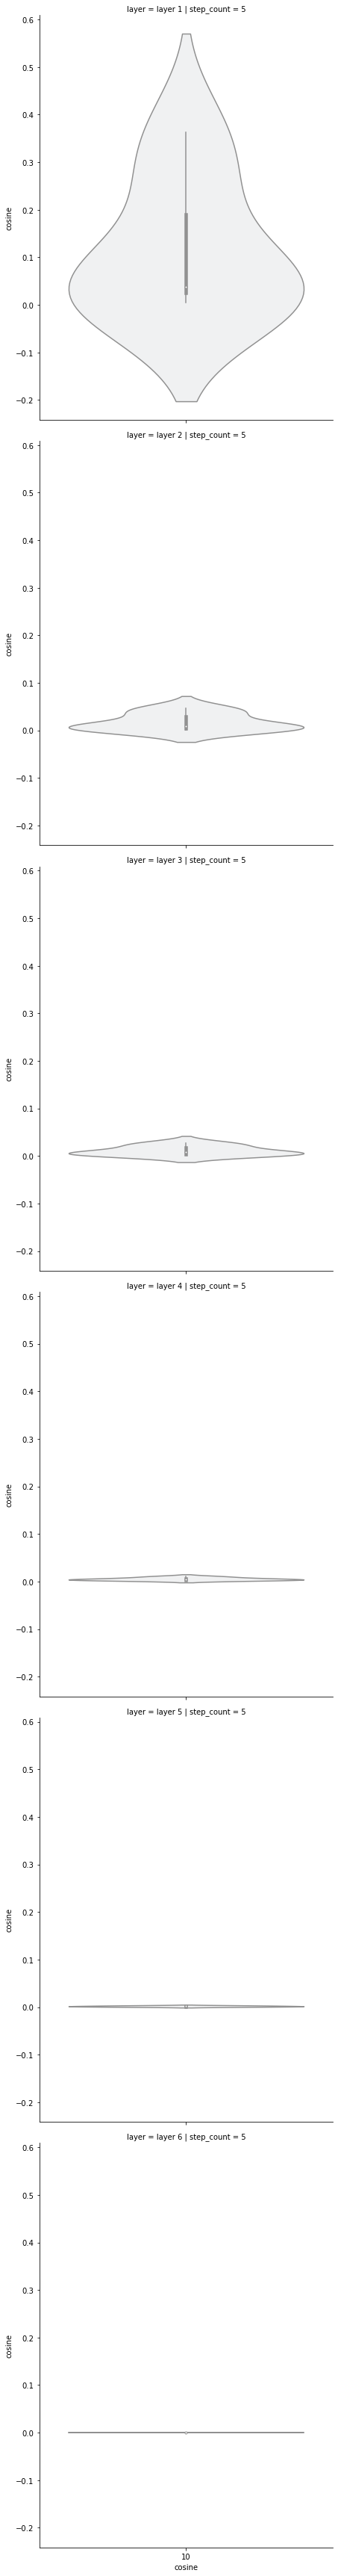

In [23]:
def make_facet(y, **kwargs):
    v = sns.violinplot(y=y,x="sample_size", hue="sample_size", **kwargs)
g = sns.FacetGrid(cosine_df, col="step_count",  row="layer", height=8, aspect=.8, sharey=True)
g.map_dataframe(make_facet, "cosine")
plt.show()

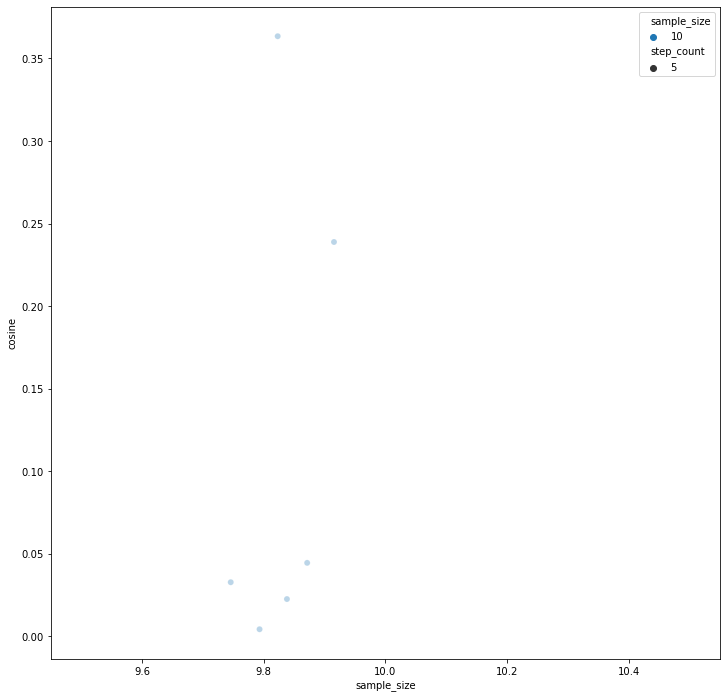

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
#sns.swarmplot(data=cosine_df, x="sample_size", y="cosine", hue="step_count", ax=ax)
sns.scatterplot(data=cosine_df[cosine_df['layer'] == "layer 1"], x="sample_size", y="cosine", style="step_count", hue="sample_size", alpha=0.3, ax=ax)

dots = ax.collections[0]
offsets = np.array(dots.get_offsets())
#print(offsets[10:,:], offsets.shape)
jitter = np.random.uniform(-0.3,0.3, offsets.shape[0])
jittered_offsets = offsets
jittered_offsets[:,0] += jitter
#print(jittered_offsets[10:,:])
dots.set_offsets(jittered_offsets)

#plt.tight_layout()
plt.show()

In [18]:
(full_df
     .groupby(['variable', 'sample', 'sent', 'layer'])
     .agg({'value': np.max})
     .groupby(['variable', 'sample', 'sent'])
     .agg({'value': [np.median, np.max, np.sum, np.std]})
)

value                              
                        median      amax       sum       std
variable sample sent                                        
clearly  0      1     0.471463  0.550094  2.725369  0.080882
         1      1     0.460582  0.518337  2.459831  0.157290
         2      1     0.435034  0.497976  2.536871  0.075096
rabbit   0      0     0.665136  0.859415  4.029142  0.117989
         1      0     0.624286  0.842007  3.691535  0.170877
         2      0     0.656356  0.862868  3.867883  0.159437

In [20]:
html = html_for_sentences(full_df, ["sent", "layer", "sample"])
display(HTML(html))

MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9
MASK INDEX 9


In [ ]:
html = html_for_sentences(full_df, mask_index, ["sample", "layer", "sent"])
display(HTML(html))